<a href="https://www.kaggle.com/code/allenmoreno/nba-rookie-season-predictor?scriptVersionId=180202391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm  # Importing statsmodels

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nba-player-data/NBA_Player_Data_Test_Sample.xlsx
/kaggle/input/nba-player-rookie-stats-and-college-stats/NBA_Player_Data.xlsx


In [2]:
file_path = "/kaggle/input/nba-player-data/NBA_Player_Data_Test_Sample.xlsx"
df = pd.read_excel(file_path)
print(df.head())

  NBA Player             College_PPG  College_AST  College_REB  College_STL  \
0              AJ Green         17.9          2.6          3.3          0.7   
1       Andrew Nembhard         11.8          5.8          3.0          1.6   
2          Anthony Gill         13.8          0.6          6.1          0.6   
3           Bam Adebayo         13.0          0.8          8.0          0.7   
4          Bradley Beal         14.8          2.2          6.7          1.4   

   College_3PT  NBA_PPG  NBA_AST  NBA_REB  NBA_STL  NBA_3PT  College_FG  \
0        0.378      4.5      0.6      1.2      0.2    0.419       0.414   
1        0.347      9.5      4.5      2.7      1.1    0.354       0.430   
2        0.000      1.9      0.3      1.9      0.2    0.200       0.583   
3        0.000      6.9      1.5      5.5      0.5    0.000       0.599   
4        0.339     22.1      4.2      4.1      1.0    0.372       0.445   

   NBA_FG Position  Pick  Year  
0   0.424        G     0  2022  
1   0.44

In [3]:
# Statistics for college stats
college_stats_summary = df[['College_PPG', 'College_AST', 'College_REB','College_3PT','College_FG']].describe()

print(college_stats_summary)

       College_PPG  College_AST  College_REB  College_3PT  College_FG
count    54.000000    54.000000    54.000000    54.000000   54.000000
mean     14.337037     2.601852     6.157407     0.328500    0.476833
std       3.262439     1.743721     2.315624     0.095676    0.064404
min       7.900000     0.500000     2.400000     0.000000    0.349000
25%      12.025000     1.425000     4.525000     0.298000    0.430250
50%      13.950000     2.150000     5.850000     0.348000    0.454500
75%      16.525000     3.425000     7.475000     0.386750    0.510250
max      22.600000     7.600000    11.600000     0.450000    0.622000


In [4]:
# Statistics for NBA stats
nba_stats_summary = df[['NBA_PPG', 'NBA_AST', 'NBA_REB','NBA_3PT','NBA_FG']].describe()

print(nba_stats_summary)

         NBA_PPG    NBA_AST    NBA_REB    NBA_3PT     NBA_FG
count  54.000000  54.000000  54.000000  54.000000  54.000000
mean    7.433333   1.666667   3.568519   0.302778   0.434907
std     4.803340   1.394057   2.344309   0.089507   0.071109
min     1.100000   0.200000   0.700000   0.000000   0.263000
25%     3.800000   0.900000   1.750000   0.261500   0.392500
50%     6.600000   1.300000   2.950000   0.331500   0.432000
75%    10.950000   1.800000   5.200000   0.358250   0.459000
max    22.100000   6.400000  10.800000   0.430000   0.632000


In [5]:
#Matrix of correlation for every variable
correlation_matrix = df[['College_PPG', 'College_AST', 'College_REB', 'College_FG', 'College_3PT', 
                         'NBA_PPG', 'NBA_AST', 'NBA_REB', 'NBA_FG', 'NBA_3PT']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
             College_PPG  College_AST  College_REB  College_FG  College_3PT  \
College_PPG     1.000000    -0.071785     0.312081    0.202257     0.069792   
College_AST    -0.071785     1.000000    -0.283994   -0.366058     0.290048   
College_REB     0.312081    -0.283994     1.000000    0.563264    -0.380470   
College_FG      0.202257    -0.366058     0.563264    1.000000    -0.358631   
College_3PT     0.069792     0.290048    -0.380470   -0.358631     1.000000   
NBA_PPG         0.453419     0.019253     0.375971    0.249370    -0.009952   
NBA_AST         0.039854     0.725528     0.031465   -0.114953     0.038732   
NBA_REB         0.284155    -0.151794     0.745076    0.557084    -0.329262   
NBA_FG          0.176196    -0.369571     0.603240    0.653317    -0.468384   
NBA_3PT         0.088834     0.086911    -0.155787   -0.246529     0.398114   

              NBA_PPG   NBA_AST   NBA_REB    NBA_FG   NBA_3PT  
College_PPG  0.453419  0.039854  0.284155  0.

In [6]:
#Define Model Variables
X = df[['College_3PT', 'College_AST', 'College_REB', 'College_FG', 'College_PPG']]
# Change y for each NBA Variable to obtain all data
y = df['NBA_PPG']

In [7]:

     for col in X.columns:
    # Add constant term for intercept
    X_with_const = sm.add_constant(X[col])
    # Fit the linear regression model
    model = sm.OLS(y, X_with_const).fit()
    # Get the coefficients
    r_value = np.sign(model.params[col]) * np.sqrt(model.rsquared)
    intercept, slope = model.params['const'], model.params[col]
    # Print results
    print(f"\nCollege Stat: {col}")
    print("Equation: NBA_PPG = {:.2f} + {:.2f} * {}".format(intercept, slope, col))
    print("Correlation Coefficient (R-value):", r_value)
    print("R-squared:", model.rsquared)
    print("P-value:", model.pvalues[col])


College Stat: College_3PT
Equation: NBA_PPG = 7.60 + -0.50 * College_3PT
Correlation Coefficient (R-value): -0.009951949963423086
R-squared: 9.904130807447675e-05
P-value: 0.9430617969649373

College Stat: College_AST
Equation: NBA_PPG = 7.30 + 0.05 * College_AST
Correlation Coefficient (R-value): 0.0192530967883326
R-squared: 0.00037068173594090315
P-value: 0.8900957548354902

College Stat: College_REB
Equation: NBA_PPG = 2.63 + 0.78 * College_REB
Correlation Coefficient (R-value): 0.3759710374524973
R-squared: 0.14135422100310713
P-value: 0.005082420534509963

College Stat: College_FG
Equation: NBA_PPG = -1.44 + 18.60 * College_FG
Correlation Coefficient (R-value): 0.24937013758603954
R-squared: 0.062185465519680294
P-value: 0.06899431518135281

College Stat: College_PPG
Equation: NBA_PPG = -2.14 + 0.67 * College_PPG
Correlation Coefficient (R-value): 0.45341877329947966
R-squared: 0.20558858398040492
P-value: 0.0005748561168229885


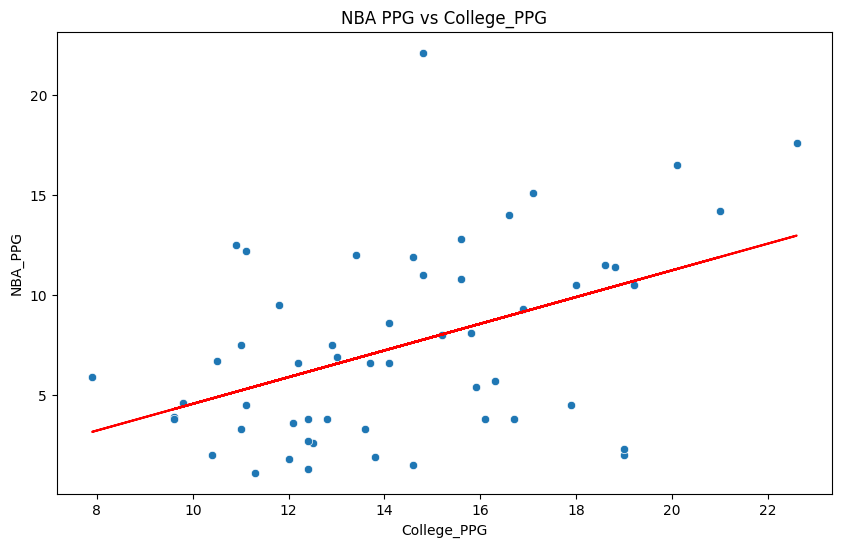

In [8]:
 # Plotting the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[col], y=y)
plt.plot(X[col], model.predict(X_with_const), color='red')
plt.xlabel(col)
plt.ylabel('NBA_PPG')
plt.title(f'NBA PPG vs {col}')
plt.show()

In [9]:
# Define predictor variables (X) and target variable (y)
X = df[['College_3PT', 'College_AST', 'College_REB', 'College_FG', 'College_PPG']]
y = df['NBA_PPG']

# Split the data into training and test sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Print dimensions of training and test data
print("Training Data Dimensions:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nTest Data Dimensions:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# Add constant term for intercept for training and test data
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the multiple linear regression model on training data
model = sm.OLS(y_train, X_train_with_const).fit()

# Print model summary
print("\nModel Summary:")
print(model.summary())

# Make predictions on test data
y_pred_test = model.predict(X_test_with_const)

# Calculate R-squared value on test data
r_squared_test = r2_score(y_test, y_pred_test)
print("\nR-squared on Test Data:", r_squared_test)

# Now let's check the correlation of predicted values with the original NBA_PPG in the test dataset
test_df = pd.concat([X_test, y_test], axis=1)
test_df['Predicted_NBA_PPG'] = y_pred_test
correlation_predicted = test_df[['NBA_PPG', 'Predicted_NBA_PPG']].corr().iloc[0, 1]
print("Correlation of Predicted NBA_PPG with Original NBA_PPG (Test Data):", correlation_predicted)

Training Data Dimensions:
X_train: (27, 5)
y_train: (27,)

Test Data Dimensions:
X_test: (27, 5)
y_test: (27,)

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                NBA_PPG   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.524
Date:                Tue, 28 May 2024   Prob (F-statistic):              0.225
Time:                        07:24:30   Log-Likelihood:                -71.526
No. Observations:                  27   AIC:                             155.1
Df Residuals:                      21   BIC:                             162.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---

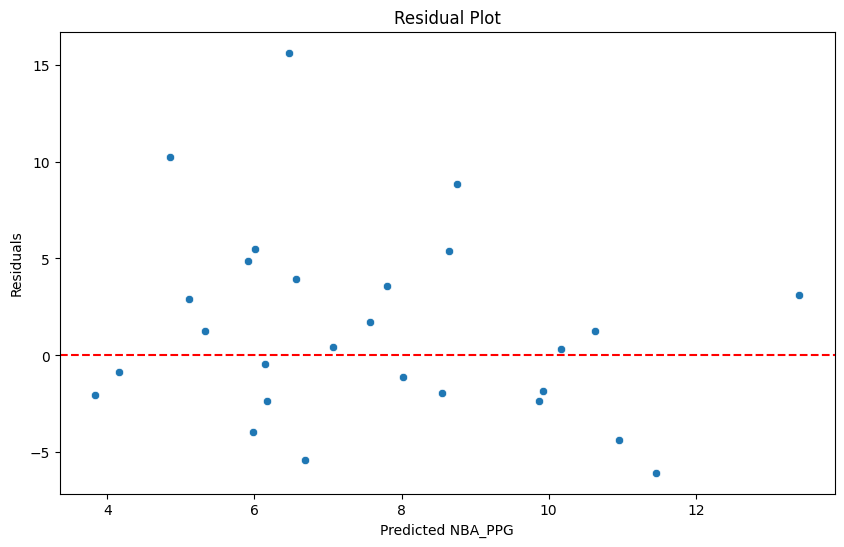

In [10]:

# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted NBA_PPG')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()